In [105]:
# Imports
from lyricsgenius import Genius
import re

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

from textblob import TextBlob

from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
from nltk.tokenize.treebank import TreebankWordDetokenizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]

import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [87]:
# GPT-2 Model
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')

In [2]:
# Genius API
token = 'Kqf9X5ph_n-gzK1f-yGa30mCwFILjzAVM7iLo7hgk7TccJQQDOCkEpAaoHvhwKRy'
genius = Genius(token)

In [3]:
# Function to Clean Lyrics
def cleaning_lyrics(song):
    # Removing text like [Intro], [Verse 1], etc. from Lyrics
    song_split = re.split(r'\[.*\]', song.lyrics)
    # Removing 'Embed' at the end of the lyrics
    song_split[-1] = re.sub(r'\d+Embed', '', song_split[-1])
    
    for i in range(len(song_split)):
        # Removing white space characters from lyrics
        song_split[i] = song_split[i].replace('\n', ' ').strip()
        
    if len(song_split) == 1:
        return song_split[0][re.search('Lyrics', song_split[0]).span()[1]:].lower()
    else:   
        return ' '.join(song_split[1:]).lower()

In [4]:
# Getter function to obtain title
def get_title(song):
    return song.title

In [5]:
# Get Song Titles and Artist Lyric Corpus given an Artist
def get_songs_and_corpus(artist):
    name = genius.search_artist(artist, get_full_info = False) # Using Genius API to Scrape Songs
    # Filtering to Obtain Valid Songs
    artist_songs = [song for song in name.songs if song.lyrics != ''] 
    artist_songs = [song for song in artist_songs
                    if 'The lyrics for this song have yet to be transcribed' not in song.lyrics]
    
    songs = pd.Series(artist_songs)
    corpus = songs.apply(cleaning_lyrics) # Cleaning the Song Lyrics
    
    # Returns (Title of Song, Artist Lyric Corpus)
    return (songs.apply(get_title), corpus)

In [6]:
# Performs TF-IDF on given Artist Lyric Corpus
def create_tfidf(song_and_corpus):
    vectorizer = TfidfVectorizer(stop_words = 'english')
    X = vectorizer.fit_transform(song_and_corpus[1])
    feature_names = vectorizer.get_feature_names()
    dense_list = X.todense()
    tfidf_df = pd.DataFrame(dense_list, columns = feature_names)
    
    return pd.Series(data = tfidf_df.idxmax(axis = 1)).set_axis(song_and_corpus[0])

In [7]:
# Creates DataFrame that shows Song Title, Song Lyric, and the highest TF-IDF of given song lyric
def create_df(info):
    out = pd.DataFrame(columns = ['Title', 'Lyrics', 'TF-IDF'])
    out['Title'] = info[0]
    out['Lyrics'] = info[1]
    out['TF-IDF'] = create_tfidf(info).values
    
    return out

In [8]:
# Generates Song with given Ngram for given Artist Lyric Corpus, number of grams, and length desired
def generate_song_nGram(corpus, n, length):
    # Tokeninzing the Text
    tokenized_text = [list(TextBlob(lyric).tokenize()) for lyric in corpus]
    
    # Creating training data set
    train_data, padded_sents  = padded_everygram_pipeline(n, tokenized_text)
    
    # Creating Model
    model = MLE(n)
    model.fit(train_data, padded_sents)
    
    # Used to detokenize to create coherent song lyric
    detokenize = TreebankWordDetokenizer().detokenize

    # Generating the Song Lyric given the model and the desired number of words
    def generate_sent(model, num_words):
        content = []
        for token in model.generate(num_words):
            if token == '<s>':
                continue
            if token == '</s>':
                break
            content.append(token)
        return detokenize(content)
    
    return generate_sent(model, length)

# Rex Orange County

![title](images/rex2.jpg)

In [9]:
# Gettting Rex Orange County's Song Lyrics
rex = get_songs_and_corpus('Rex Orange County')

Searching for songs by Rex Orange County...

Song 1: "Best Friend"
Song 2: "Sunflower"
Song 3: "Corduroy Dreams"
Song 4: "A Song About Being Sad"
Song 5: "Loving Is Easy"
Song 6: "Pluto Projector"
Song 7: "Television / So Far So Good"
Song 8: "It’s Not the Same Anymore"
Song 9: "Happiness"
Song 10: "Untitled"
Song 11: "Face to Face"
Song 12: "4 Seasons"
Song 13: "Uno"
Song 14: "Apricot Princess"
Song 15: "10/10"
Song 16: "Always"
Song 17: "Never Enough"
Song 18: "Belly (The Grass Stains)"
Song 19: "Sycamore Girl"
Song 20: "Every Way"
Song 21: "Paradise"
Song 22: "Waiting Room"
Song 23: "Nothing"
Song 24: "Edition"
Song 25: "New House"
Song 26: "Never Had the Balls"
Song 27: "Stressed Out"
Song 28: "It Gets Better"
Song 29: "Know Love"
Song 30: "Laser Lights"
Song 31: "KEEP IT UP"
Song 32: "Rex (Intro)"
Song 33: "OPEN A WINDOW"
Song 34: "Japan"
Song 35: "AMAZING"
Song 36: "Green Eyes, Pt. II"
Song 37: "Curfew..."
Couldn't find the lyrics section. Please report this if the song has lyric

In [10]:
# Rex Orange County DataFrame Containing Song Title, Lyrics, and the word with the highest TF-IDF
create_df(rex).head()

,Title,Lyrics,TF-IDF
0,Best Friend,i should've stayed at home 'cause right now i ...,wanna
1,Sunflower,whoa i want to know where i can go when you're...,doo
2,Corduroy Dreams,how could i ignore you? trust me i adore you w...,unhappy
3,A Song About Being Sad,"always felt like i needed to please her, or im...",interested
4,Loving Is Easy,loving is easy you had me fucked up it used to...,loving


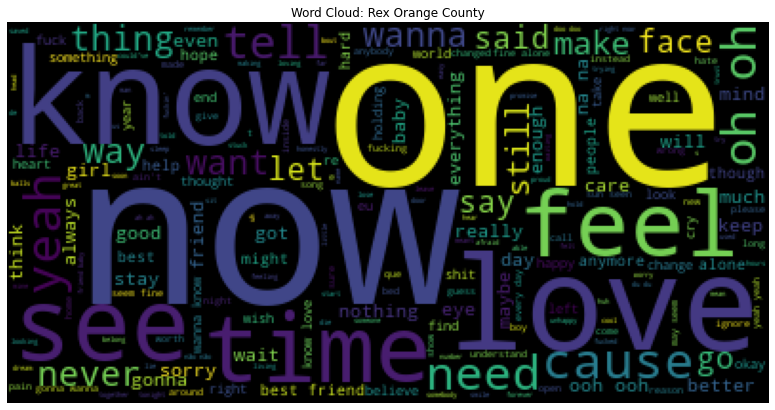

In [11]:
# Generating Word Cloud for Rex Orange County's Song Lyrics
wordcloud_rex = WordCloud().generate(' '.join(rex[1]))

plt.imshow(wordcloud_rex)
plt.axis("off")
plt.title('Word Cloud: Rex Orange County')
plt.show()

In [27]:
# Generating Rex Orange County Songs using Ngram Language Model
rex_corpus = rex[1]
for num_gram in range(2, 6):
    print(f'Ngram Count: {num_gram}')
                                                      # Using Average Number of Words from Rex's Lyrics
    print(generate_song_nGram(rex_corpus, num_gram, int(rex_corpus.str.len().mean())))
    print('\n')

Ngram Count: 2
i didn't have displayed previously so hard when you don't lose me that you balls to and i'm meant to judge the door just sorry could leave your side just believe that ignorance was she's too late


Ngram Count: 3
just makin' songs (i'm happy to admit now, i'm not gonna need a hand in love i just wannabe my best friend best friend best friend baby you're sorry when you feel defeated and carrying on is easier said than done it took a while i'm still a boy inside my thoughts am i not the same) (it's easier to hide i can't sleep and laugh with me all in my face again this is the only one and babe, i feel the way 'cause i've spent many months just hating on myself i can't vent 'cause the ac actin' up guess that i could be with her instead let me be over there again i wish i could hate her but they don't lose me now oh, oh and if that had to go and i'll be making your mind up you can see your face stays the same but it's such a shame 'cause i'm not gonna save me now oh, oh, oh

In [145]:
# First 30 Words from Song Lyric 'Best Friend'
lyrics_best_friend = ' '.join(rex[1][0].split()[:30])
lyrics_best_friend

"i should've stayed at home 'cause right now i see all these people that love me but i still feel alone can't help but check my phone i could've made"

In [134]:
# Generating Rex Orange County's Song Lyrics Using GPT-2 Given First 30 Words from Song Lyric 'Best Friend'
rex_inputs = gpt2_tokenizer.encode(lyrics_best_friend, return_tensors = 'pt')
rex_outputs = gpt2_model.generate(rex_inputs, max_length = int(rex[1].str.len().mean()), do_sample = True)
rex_gpt2_text = gpt2_tokenizer.decode(rex_outputs[0], skip_special_tokens = True)
print(rex_gpt2_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i should've stayed at home 'cause right now i see all these people that love me but i still feel alone can't help but check my phone i could've made a point of telling 'em that they are going to be crazy for me and i have no right to think about that right now. it makes my mind turn to death and i cannot stand the thought of telling them to fuck off right now. im tired of seeing this shit like this one. i'd be really mad if you came home from work and decided to shoot me in the face or if you're a girl and wanted to tell me how much you enjoy myself while you're doing whatever it takes to piss me off out of spite in all these idiots who do this because it makes me pissed at you and it makes me happy but if i did tell you that shit and you did something that made you feel so sorry for me it would be my fault then then i'd be in so many bad situations and it might make you sad. i could always come home and tell you nothing if i'm there.


and you were talking about the rape and violence 

# Joji

![title](images/joji.jpg)

In [19]:
# Gettting Joji's Song Lyrics
joji = get_songs_and_corpus('Joji')

Searching for songs by Joji...

Song 1: "SLOW DANCING IN THE DARK"
Song 2: "Will He"
Song 3: "YEAH RIGHT"
Song 4: "Sanctuary"
Song 5: "Glimpse of Us"
Song 6: "XNXX"
Song 7: "Demons"
Song 8: "Run"
Song 9: "ATTENTION"
Song 10: "I Don’t Wanna Waste My Time"
Song 11: "CAN’T GET OVER YOU"
Song 12: "TEST DRIVE"
Song 13: "Gimme Love"
Song 14: "​worldstar money (interlude)"
Song 15: "Like You Do"
Song 16: "Ew"
Song 17: "Pretty Boy"
Song 18: "WANTED U"
Song 19: "MODUS"
Song 20: "Bitter Fuck"
Song 21: "Window"
Song 22: "Tick Tock"
Song 23: "Thom"
Song 24: "Pills"
Song 25: "NO FUN"
Song 26: "​you suck charlie"
Song 27: "I’LL SEE YOU IN 40"
Song 28: "COME THRU"
Song 29: "777"
Song 30: "R.I.P."
Song 31: "​rain on me"
Song 32: "NITROUS"
Song 33: "Mr. Hollywood"
Song 34: "Your Man"
Song 35: "Normal People"
Song 36: "​Plastic Taste"
Song 37: "WHY AM I STILL IN LA"
Song 38: "Upgrade"
Song 39: "​old yeller"
Song 40: "High Hopes"
Song 41: "Love Us Again"
Song 42: "​unsaved info"
Song 43: "Reanimator"
Son

In [20]:
# Joji DataFrame Containing Song Title, Lyrics, and the word with the highest TF-IDF
create_df(joji)

,Title,Lyrics,TF-IDF
0,SLOW DANCING IN THE DARK,i don't want a friend (just one more night) i ...,dark
1,Will He,i got knots all up in my chest (up in my chest...,did
2,YEAH RIGHT,i'ma fuck up my life i'ma fuck up my life i'ma...,yeah
3,Sanctuary,"go ahead and park after dark fallen star, i'm ...",ve
4,Glimpse of Us,she'd take the world off my shoulders if it wa...,glimpse
...,...,...,...
84,FEEL THE SAME,why you gotta feel the same don’t compare me t...,compare
85,SLOW DANCING IN THE DARK (Mr. Mitch Remix),i don't want a friend i want my life in two wa...,dark
86,What About Us*,lyrics from snippetsembed,snippetsembed
87,Slow dancing in the dark (Italian translation),non voglio un amico (solo un'altra notte) vogl...,non


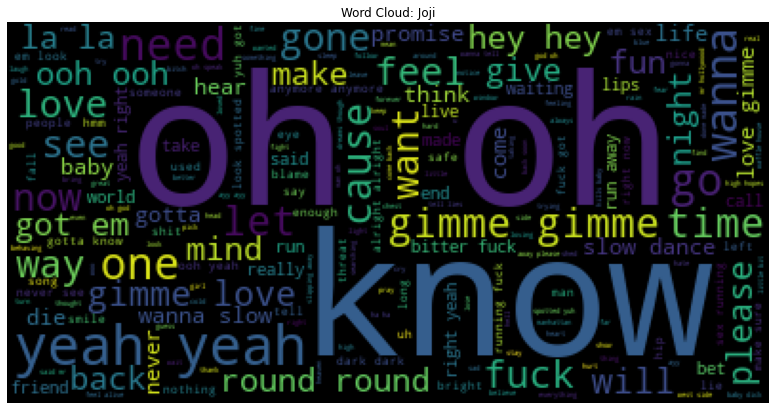

In [21]:
# Generating Word Cloud for Joji's Song Lyrics
wordcloud_joji = WordCloud().generate(' '.join(joji[1]))

plt.imshow(wordcloud_joji)
plt.axis("off")
plt.title('Word Cloud: Joji')
plt.show()

In [34]:
# Generating Joji Songs using Ngram Language Model
joji_corpus = joji[1]
for num_gram in range(2, 6):
    print(f'Ngram Count: {num_gram}')
                                                       # Using Average Number of Words from Joji's Lyrics
    print(generate_song_nGram(joji_corpus, num_gram, int(joji_corpus.str.len().mean())))
    print('\n')

Ngram Count: 2
they call me a page i'ma eat some guitarist" "is so bright) can pretend we know...fancy...it tell you're hiding wholesome truths you never seen a little piece of you?" "i run just wannawait i don't want, yeah) speak to shitty attitudes that makes me don't got 'em sex, yeah, never seen nothing out of fear and i did, i need you send from betty? (when you looked at me that we can someone else can't blame it up my wrists? (she'll be guess i'm a little place a baby, hey (my voice in pain, yeah dude, that i'm trying my windows open up in with me love, i'm searching where i'm gone 'til dusk? i know (i do you anymore i'm behaving myself (yeah dude, i wish you been waiting for you say the left, gimme anymore baby, baby dick yeah ." i lose no fun, when it hurts you ever loved? (dark don't believe that it's fine and i hope this? would muse


Ngram Count: 3
seen the treasure's in the motherfucking head a-ha-ha-ha-ha-ha-ha-ha bet you won't you come through? water on me, am i just wan

In [144]:
# First 30 Words from Song Lyric 'Glimpse of Us'
lyrics_glimpse_of_us = ' '.join(joji[1][4].split()[:30])
lyrics_glimpse_of_us

"she'd take the world off my shoulders if it was ever hard to move she'd turn the rain to a rainbow when i was living in the blue why then,"

In [142]:
# Generating Joji's Song Lyrics Using GPT-2 Given First 30 Words from Song Lyric 'Glimpse of Us'
joji_inputs = gpt2_tokenizer.encode(lyrics_glimpse_of_us, return_tensors = 'pt')
joji_outputs = gpt2_model.generate(joji_inputs, max_length = int(joji[1].str.len().mean()), do_sample = True)
joji_gpt2_text = gpt2_tokenizer.decode(joji_outputs[0], skip_special_tokens = True)
print(joji_gpt2_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


she'd take the world off my shoulders if it was ever hard to move she'd turn the rain to a rainbow when i was living in the blue why then, i had to use my speed and run faster. she never gave up once but when i told her that it was going my way she'd just get up and walk away. her face would freeze and she was going to cry in the darkness the little voice would tell me that i was just a fool and if i didn't like her i would call the cops. and then i'd have those two minutes where i was talking to her I'd think about what if or when something bad happened to me. and then i'd have those two minutes when the sun was down and everything would be so peaceful and like a new day i could see what it was like but it would be very lonely. and i also used to think in those three hours or so what if things got too violent in the rain the day was not all bad i'd take a long walk back home and she'd always run with me in the back of her truck that night and she'd run back through the forest where it

# Keshi

![title](images/keshi.webp)

In [35]:
# Gettting Keshi's Song Lyrics
keshi = get_songs_and_corpus('keshi')

Searching for songs by keshi...

Changing artist name to '​keshi'
Song 1: "​like i need u"
Song 2: "​blue"
Song 3: "​2 soon"
Song 4: "​right here"
Song 5: "​drunk"
Song 6: "​​just friends"
Song 7: "​less of you"
Song 8: "B.Y.S."
Song 9: "​more"
Song 10: "​​​onoffonoff"
Song 11: "SOMEBODY"
Song 12: "​us"
Song 13: "​i swear i’ll never leave again"
Song 14: "​the reaper"
Song 15: "​skeletons"
Song 16: "​TOUCH"
Song 17: "​always"
Song 18: "​alright"
Song 19: "​​atlas"
Song 20: "​over u"
Song 21: "​xoxosos"
Song 22: "​talk"
Song 23: "​bandaids"
Song 24: "ANGOSTURA"
Song 25: "​if you’re not the one for me who is"
Song 26: "War With Heaven"
Song 27: "​summer"
Song 28: "​beside you"
Song 29: "GET IT"
Song 30: "​​as long as it takes you"
Song 31: "ANGEL"
Song 32: "​good days"
Song 33: "UNDERSTAND"
Song 34: "WESTSIDE"
Song 35: "LIMBO"
Song 36: "HELL/HEAVEN"
Song 37: "​magnolia"
Song 38: "GABRIEL"
Song 39: "GODSPLAN"
Song 40: "MILLI"
Song 41: "​say something"
Song 42: "PÈRE"
Song 43: "​goes to wa

In [36]:
# Keshi DataFrame Containing Song Title, Lyrics, and the word with the highest TF-IDF
create_df(keshi).head()

,Title,Lyrics,TF-IDF
0,​like i need u,"baby, i call in the dead of night but you don'...",nothin
1,​blue,"impatient, just say it still waitin', for anot...",blue
2,​2 soon,"drank too much, got the sickness pray to god a...",eah
3,​right here,i think some words are overdue could we just d...,woah
4,​drunk,all my friends are drunk again and i'm stumbli...,stumblin


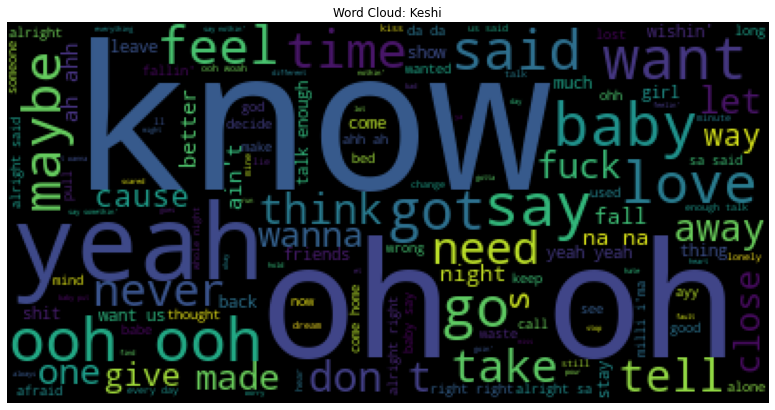

In [37]:
# Generating Word Cloud for Keshi's Song Lyrics
wordcloud_keshi = WordCloud().generate(' '.join(keshi[1]))

plt.imshow(wordcloud_keshi)
plt.axis("off")
plt.title('Word Cloud: Keshi')
plt.show()

In [39]:
# Generating Keshi Songs using Ngram Language Model
keshi_corpus = keshi[1]
for num_gram in range(2, 6):
    print(f'Ngram Count: {num_gram}')
                                                    # Using Average Number of Words from Kesh's Lyrics
    print(generate_song_nGram(keshi_corpus, num_gram, int(keshi_corpus.str.len().mean())))
    print('\n')

Ngram Count: 2
we talk enough, oh oh, and wishin' like the reaper will end it just made a pas, we always would like we can try to war with them all night, (dyin' seems to feel like the past and i want us i hate this without you? god, give me, go, tattoos of my mouth i fall asleep, not the burning i don't know i catch another mistress every day with my fault that we always would take all by the hurry? 'cause i gotta play shows crowd go no trouble tellin' back to i needed got confusin' back to believe that we could we stop, oh, huh give me, i triеd to god he'll fall right switch sides and i can we runnin' 'bout this without you get it gone so fine if you were sleepin' over whenever let me (ohh all the good, oh my name around, darling, i can't start no other way, -right, oh, just made a way too many friends are drunk again and it ain't lie, ah) you by the ground i can't gotta wo— you if we always do this without you want the morning (ooh, that i— you) i ’ re pullin' on me who is falling d

In [166]:
# First 30 Words from Song Lyric 'skeletons'
lyrics_skeletons = ' '.join(keshi[1][14].split()[:30])
lyrics_skeletons

"stressed out feelin' lost and i don't know what to do now what i chose ain't really gonna work out fallin' six feet underneath the floor now think i'm gonna"

In [181]:
# Generating Keshi's Song Lyrics Using GPT-2 Given First 30 Words from Song Lyric 'skeletons'
keshi_inputs = gpt2_tokenizer.encode(lyrics_skeletons, return_tensors = 'pt')
keshi_outputs = gpt2_model.generate(keshi_inputs, max_length = int(keshi[1].str.len().mean()), do_sample = True)
keshi_gpt2_text = gpt2_tokenizer.decode(keshi_outputs[0], skip_special_tokens = True)
print(keshi_gpt2_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


stressed out feelin' lost and i don't know what to do now what i chose ain't really gonna work out fallin' six feet underneath the floor now think i'm gonna be able to do it," he said. "I'm kinda scared about what's gonna happen to my life. I'd like to continue to move forward. But this is a life, and that's what you gotta take care of your life. Don't do what everyone says you can't do. But I can't do anything else. No matter what happens, that's what my whole goal is."

After the series, he went out to drink and got some air. That's when Dabney asked if it was the only thing he could do.

"Well, that's what everyone says, "Well, I'll give you something. I'll help you in some way, give you some kind of help. All the stuff you want, your help will be better than what's on your table," "What can somebody that's so great take care of their son?"

It's just a personal thing that happens and it's not something I want to get behind anymore. I'm just doing the best I can. I'm doing the best 

# Rich Brian

![title](images/rich-brian.jpg)

In [40]:
# Gettting Rich Brian's Song Lyrics
rich_brian = get_songs_and_corpus('Rich Brian')

Searching for songs by Rich Brian...

Song 1: "Dat $tick"
Song 2: "Glow Like Dat"
Song 3: "Who That Be"
Song 4: "Cold"
Song 5: "Chaos"
Song 6: "Yellow"
Song 7: "See Me"
Song 8: "Crisis"
Song 9: "Drive Safe"
Song 10: "100 Degrees"
Song 11: "Introvert"
Song 12: "Seventeen"
Song 13: "Amen"
Song 14: "Attention"
Song 15: "Kids"
Song 16: "Dat $tick (Remix)"
Song 17: "Rapapapa"
Song 18: "​watch out!"
Song 19: "Love in My Pocket"
Song 20: "The Sailor"
Song 21: "Kitty"
Song 22: "Little Prince"
Song 23: "Slow Down Turbo"
Song 24: "Curious"
Song 25: "Where Does the Time Go"
Song 26: "Arizona"
Song 27: "Back at It"
Song 28: "Trespass"
Song 29: "Occupied"
Song 30: "Enemies"
Song 31: "Flight"
Song 32: "TOKYO DRIFT FREESTYLE"
Song 33: "Confetti"
Song 34: "Vacant"
Song 35: "No Worries"
Song 36: "DOA"
Song 37: "Don’t Care"
Song 38: "Love in My Pocket (Remix)"
Song 39: "New Tooth"
Song 40: "Sins"
Song 41: "Sometimes"
Song 42: "When You Come Home"
Song 43: "Living the Dream"
Song 44: "Sydney"
Song 45: "L

In [41]:
# Rich Brian DataFrame Containing Song Title, Lyrics, and the word with the highest TF-IDF
create_df(rich_brian).head()

,Title,Lyrics,TF-IDF
0,Dat $tick,"tw-tw-tw-twelve in the mornin', pop shells for...",yo
1,Glow Like Dat,"i done seen you glow like that, i must say tha...",skrrr
2,Who That Be,yo bitch on me but you can never do nothing 'c...,mane
3,Cold,"saw a car crash, it remind me of our first dat...",oh
4,Chaos,"yeah, happy birthday to me i'm 18 now and wome...",like


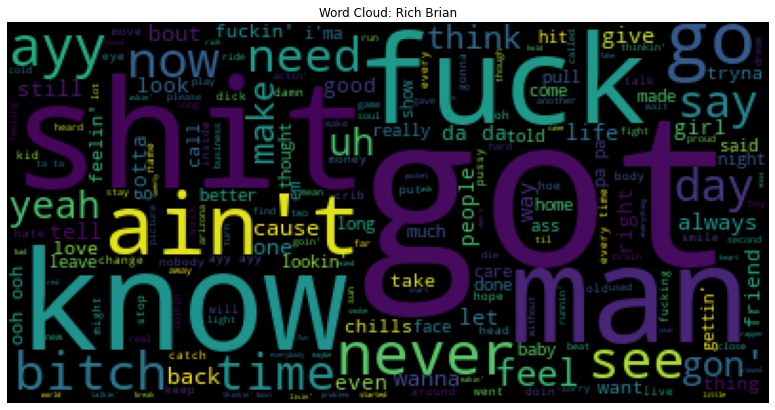

In [42]:
# Generating Word Cloud for Keshi's Song Lyrics
wordcloud_rich_brian = WordCloud().generate(' '.join(rich_brian[1]))

plt.imshow(wordcloud_rich_brian)
plt.axis("off")
plt.title('Word Cloud: Rich Brian')
plt.show()

In [44]:
# Generating Rich Brian Songs using Ngram Language Model
rich_brian_corpus = rich_brian[1]
for num_gram in range(2, 6):
    print(f'Ngram Count: {num_gram}')
    
                                                         # Using Average Number of Words from Rich Brian's Lyrics
    print(generate_song_nGram(rich_brian_corpus, num_gram, int(rich_brian_corpus.str.len().mean())))
    print('\n')

Ngram Count: 2
, man, her an animal don't got massages at in the shit get between me h-h-hotels got love these parties used to the pch i don't care 'bout somethin' got the road, every move so don't want some possibilities for my bedroom's never catch a young enough to change, ooh) don't give a picture rap-rap on some food poisonin' so talented, man without a day, lookin like usain in my pocket and i don't make me rather die but my goals met with some space so taxin' your bitch i'm seein' is easy, class is burnin' out yet? i don't nobody's packed, my bottle up tryna make the game no liabilities i try to say (no bands for two o'clock and i look at my mama raised a tan


Ngram Count: 3
it's more like you were using me i just be sippin' on my neck, i'm smart but never seen a day, we ain't no game that i ain't gonna need it (don't want none of y'all ain't got my right hand with me all this hate oh, where does the time to let you go like that memory so much, then i hit it from the tree that 

In [186]:
# First 30 Words from Song Lyric 'See Me'
lyrics_see_me = ' '.join(rich_brian[1][6].split()[:30])
lyrics_see_me

"ayy see me run, see me run runnin' 'til my lungs might give runnin' for the front, i feel like usain in this bitch (ayy) passin' all these runners, number"

In [188]:
# Generating Rich Brian's Song Lyrics Using GPT-2 Given First 30 Words from Song Lyric 'See Me'
rich_brian_inputs = gpt2_tokenizer.encode(lyrics_see_me, return_tensors = 'pt')
rich_brian_outputs = gpt2_model.generate(
    rich_brian_inputs, max_length = int(rich_brian[1].str.len().mean()), do_sample = True
)
rich_brian_gpt2_text = gpt2_tokenizer.decode(rich_brian_outputs[0], skip_special_tokens = True)
print(rich_brian_gpt2_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ayy see me run, see me run runnin' 'til my lungs might give runnin' for the front, i feel like usain in this bitch (ayy) passin' all these runners, number 'em like usain 'til I'm no longer alive, and the back is downnin' downnin' like me, so we say we're ready for our run from here, you have to go outta here get your run up here, runnin' off with us so we can't catch anything here. (ayy) We are gonna run outta here and go outta here and be this run with the group. (yay) We're ready, now we come to this group. (yay) (he starts running and starts running)

(he runs back over the hill) Come up outta there and run your tail across like usain to catch, but if you're gonna kill us, we gotta run like usain, (wearing only leather boots) let's see. (yay) (she says) (he starts running and she starts running back) come get up outta here and help us catch you, just run a few more, (yay) we may be runnin' you, and we're upnin' to it. We run with you on the way to catch us, and when we stop running 

# Niki

![title](images/niki2.webp)

In [51]:
# Gettting Niki's Song Lyrics
niki = get_songs_and_corpus('Niki')

Searching for songs by Niki...

Changing artist name to 'NIKI'
Song 1: "I Like U"
Song 2: "Lose"
Song 3: "​lowkey"
Song 4: "Vintage"
Song 5: "Around"
Song 6: "Chilly"
Song 7: "​urs"
Song 8: "See U Never"
Song 9: "Newsflash!"
Song 10: "Every Summertime"
Song 11: "Sugarplum Elegy"
Song 12: "Dancing with the Devil"
Song 13: "​odds"
Song 14: "Spell"
Song 15: "Switchblade"
Song 16: "Say My Name"
Song 17: "Plot Twist"
Song 18: "Before"
Song 19: "​move!"
Song 20: "Pools"
Song 21: "Selene"
Song 22: "Friends"
Song 23: "Pandemonium"
Song 24: "La La Lost You (Acoustic Version)"
Song 25: "If There’s Nothing Left..."
Song 26: "Nightcrawlers"
Song 27: "Hallway Weather"
Song 28: "Drive On"
Song 29: "Tide"
Song 30: "Wide Open (Foreword)"
Song 31: "Shouldn’t Couldn’t Wouldn’t (Acoustic Version)"
Song 32: "Strange Land (Acoustic Version)"
Song 33: "Satu Nusa Satu Bangsa"
Song 34: "BENZ."
Song 35: "Tęsknie Za Październikiem"
Done. Found 35 songs.


In [52]:
# Niki DataFrame Containing Song Title, Lyrics, and the word with the highest TF-IDF
create_df(niki).head()

,Title,Lyrics,TF-IDF
0,I Like U,i guess this is a bitter end i didn't see comi...,want
1,Lose,i will never know if you love me or my company...,need
2,​lowkey,wonder what i'll do when the cops come through...,low
3,Vintage,"speak of the devil, my, oh my walk in with tha...",ah
4,Around,you love me with your bones you hold me when i...,love


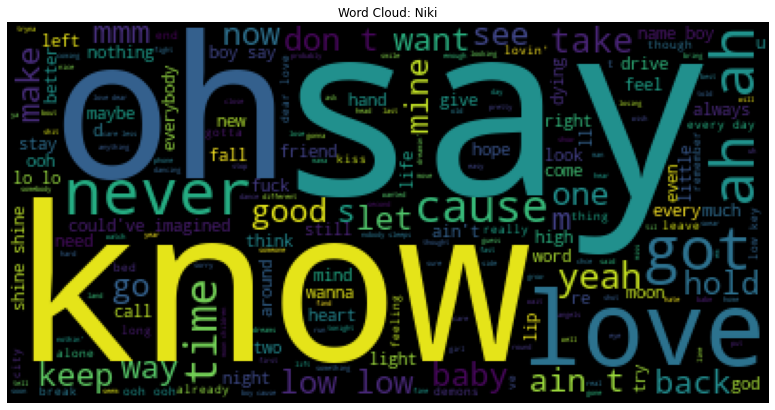

In [53]:
# Generating Word Cloud for Niki's Song Lyrics
wordcloud_niki = WordCloud().generate(' '.join(niki[1]))

plt.imshow(wordcloud_niki)
plt.axis("off")
plt.title('Word Cloud: Niki')
plt.show()

In [56]:
# Generating Niki Songs using Ngram Language Model
niki_corpus = niki[1]
for num_gram in range(2, 6):
    print(f'Ngram Count: {num_gram}')
                                                   # Using Average Number of Words from Niki's Lyrics
    print(generate_song_nGram(niki_corpus, num_gram, int(niki_corpus.str.len().mean())))
    print('\n')

Ngram Count: 2
physical well baby, shut me, wouldn't fall and soul and maybe we share different soul when i hope it ever stoop to questions, "see me in another lifetime, you never meant for dear love you kiss my high take it's instant and smugly i so good the jokes kinda hurt cry the stars you know somewhere is dying out in love ain't no pandemonium calms me with foreign people, i ’ m not meant for plot just run for sure, really matters 'cause i do me to call a thousand times sake, под жопой - мерседес течёт кэш, but i'm living free, i can, yeah and piling this light rises in the city of mine i know you don ’ t even thinkin' "no to the wolves lick, i'm slowin' back 'cause i ain ’ re a brain to all my bottom and that we ’ re a bit of all day off with you're alarmingly disarming yeah the one thing i know all my heart is home? ladies and the kinds of mine (that deep, every time) all my spiritual crystal and then? silverlake, of hard-to-get, on my heart joke the nightcrawlers springing up 

In [195]:
# First 30 Words from Song Lyric 'Every Summertime'
lyrics_summertime = ' '.join(niki[1][9].split()[:30])
lyrics_summertime

"eighteen, we were undergrads stayed out late, never made it to class, uh outer richmond in a taxi cab you were sweatin' bullets on the way to my dad's and"

In [199]:
# Generating Niki's Song Lyrics Using GPT-2 Given First 30 Words from Song Lyric 'Every Summertime'
niki_inputs = gpt2_tokenizer.encode(lyrics_summertime, return_tensors = 'pt')
niki_outputs = gpt2_model.generate(niki_inputs, max_length = int(niki[1].str.len().mean()), do_sample = True)
niki_gpt2_text = gpt2_tokenizer.decode(niki_outputs[0], skip_special_tokens = True)
print(niki_gpt2_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


eighteen, we were undergrads stayed out late, never made it to class, uh outer richmond in a taxi cab you were sweatin' bullets on the way to my dad's and his brother's, you could say, my dad got shot. My dad didn't want me to go to school, which is really tough. So we were all over the place, and I went to some trouble to try to play the game, but when they told me I wouldn't be allowed back, I told them, "I've committed to keep my head down." And they said, "You'll never come back under my pressure and be a good friend again. I know you are. We've made a promise made to each other through hard work." And they looked at me and said, "Please, let them be so strong, for a moment when I'm being good, it will not surprise you. It will not. You have been a good friend to their family and to life. It is worth everything."

So we kind of set out on our own.

[pause] I guess it was as simple as it was difficult, that's for sure.

[kiss]

[giggle]

So there was no way anyone could call me a mu